# This Notebook will help you understand some of the features football analysts or coaches use to calculate the xG value of a shot

In [254]:
#importing necessary libraries
from mplsoccer import Sbopen
from mplsoccer import Pitch, VerticalPitch, FontManager
import pandas as pd
import numpy as np
import warnings 
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import random as rn
import tensorflow as tf
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#import machine learning libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#warnings not visible on the course webpage
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
background = "black"

## We will be using data provided by Statsbomb and access it through their own API

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Before diving into the code let's list all the features we are going to use to create our model that will evaluate xG values

### 1. Distance Between the point from where the shot is being taken and the goal
### 2. The angle that the shot location makes with the goal posts
### 3. Number of opponent players in between the player taking the shot and the goal
### 4. Number of players within 3 meters of the ball/player taking the shot
### 5. The shot technique. Examples - strong foot or weak foot, headers , bicycle etc
### 6. Distance between the ball and the opponent Goalkeeper and distance between the goalkeeper and his/her goal , to calculate if the goalkeeper is closer to the ball or the goal

## This part of the code is only for my Medium article to visualize the different features we are going to use

### Reading statsbomb event data into dataframe for WC 2022

In [81]:
# iterate through all matches to get the events data
parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=106)
df_matches = {}
df_event = pd.DataFrame()
for i, id in enumerate(df_match['match_id']):
  df_matches[id] = {}
  df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)
  df_event = pd.concat([df_event,df_matches[id]['event']])

### Filtering the data to read shots taken by the Argentine team in open play (excluding penalties and free kicks) during the WC

In [82]:
mask_team = (df_event.team_name == 'Argentina') & (df_event.type_name == 'Shot') & (df_event.period <= 4) & (df_event.sub_type_name == 'Open Play')
df_team = df_event.loc[mask_team]

### PLotting all shots and clustering them based on if it was a goal or not

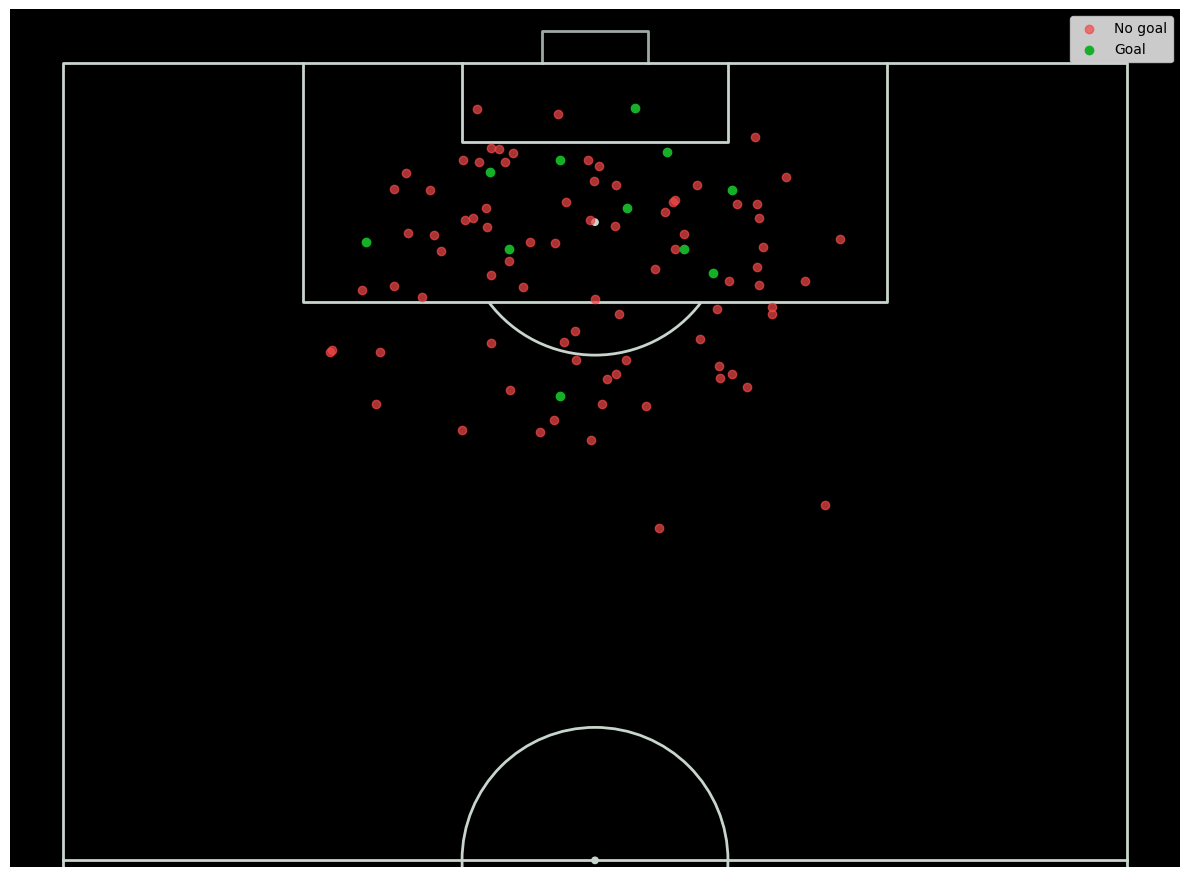

In [83]:
# visualizing shots

# filter goals / non-shot goals
df_goals = df_team[df_team.outcome_name == 'Goal'].copy()
df_non_goal_shots = df_team[df_team.outcome_name != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='black', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='#F24848',
                    marker='o',
                    ax=ax, label="No goal",alpha = 0.7)

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='#17AE28',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
plt.show()

## Reading json file which contains statsbomb 360 data for the same match ids as our event data

In [84]:
import os

df_team_360 = pd.DataFrame()
path_to_json_files = 'C:/Users/acer/Desktop/IndianCityzen/Projects/data/three-sixty/'  # Update this path to your directory containing JSON files

for match_id in df_team['match_id']:
    json_file_path = os.path.join(path_to_json_files, f'{match_id}.json')
    
    if os.path.exists(json_file_path):
        df_json = pd.read_json(json_file_path)
        df_team_360 = pd.concat([df_team_360, df_json])
    else:
        print(f"JSON file '{match_id}.json' not found at '{path_to_json_files}'.")

### Merging the two dataframes on PK

In [85]:
df_match_360 = pd.merge(left=df_team,right=df_team_360,left_on='id',right_on='event_uuid',how='left')
df_match_360 = df_match_360.drop_duplicates(subset=['id']).reset_index(drop=True)

## Function to check if a player is in between the ball and the goal

In [42]:
def point_inside_triangle(point, A, B, C):
    """Check if a point is inside the triangle formed by three other points."""
    # Unpack points
    Ax, Ay = A
    Bx, By = B
    Cx, Cy = C
    Px, Py = point

    # Compute vectors
    v0x, v0y = Cx - Ax, Cy - Ay
    v1x, v1y = Bx - Ax, By - Ay
    v2x, v2y = Px - Ax, Py - Ay

    # Compute dot products
    dot00 = v0x * v0x + v0y * v0y
    dot01 = v0x * v1x + v0y * v1y
    dot02 = v0x * v2x + v0y * v2y
    dot11 = v1x * v1x + v1y * v1y
    dot12 = v1x * v2x + v1y * v2y

    # Compute barycentric coordinates
    inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * inv_denom
    v = (dot00 * dot12 - dot01 * dot02) * inv_denom

    # Check if point is inside triangle
    return (u >= 0) and (v >= 0) and (u + v < 1)

Number of opponents behind the ball:  6
Number of opponents blocking the shot:  0
Keeper In Goal:  True
Shot Taken by:  70    Enzo Fernandez
Name: player_name, dtype: object
Shot Taken At:  70    00:41:39.636000
Name: timestamp, dtype: object
Statsbomb xG:  70    0.035064
Name: shot_statsbomb_xg, dtype: float64


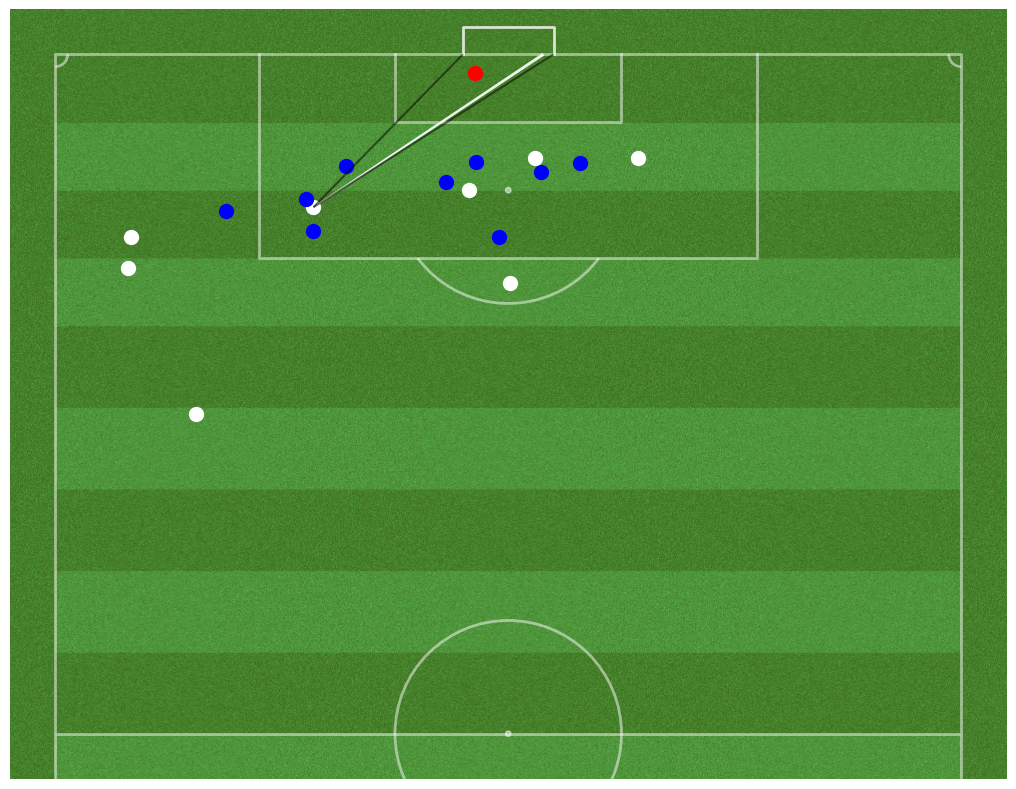

In [87]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

p = VerticalPitch(pitch_type='statsbomb',pitch_color='grass', line_color='white',stripe_color='#c2d59d', stripe=True,half=True,
                 line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')
fig,ax = p.draw(figsize=(12,8))

df_match_360_shot = df_match_360[70:71]


p.scatter(x=df_match_360_shot['x'],y=df_match_360_shot['y'],ax=ax)
p.lines(xstart=df_match_360_shot['x'],ystart=df_match_360_shot['y'],xend=df_match_360_shot['end_x'],yend=df_match_360_shot['end_y'],lw=2,alpha=0.7,comet=True,color='white',ax=ax)

opponent_count = 0
opponent_blocking_shot = 0
keeper_in_goal = False

A = (df_match_360_shot['x'].iloc[0],df_match_360_shot['y'].iloc[0])
B = (120,36)
C = (120,44)

for x in df_match_360_shot.iloc[0]['freeze_frame']:
    if x['teammate'] == True:
        color = 'white'
    elif x['teammate'] == False:
        color = 'blue'
        if x['keeper'] == False and x['location'][0] > df_match_360_shot['x'][70] and x['location'][0] > df_match_360_shot['y'][70]:
            opponent_count += 1
    if x['keeper'] == True:
        color = 'red'
        keeper_in_goal = True

    p.scatter(x=x['location'][0],y=x['location'][1],ax=ax,c = color,s=100)
    #print(x['location'][1])
    point = (x['location'][0],x['location'][1])
    #print(point)
    if point_inside_triangle(point, A, B, C).any():
        opponent_blocking_shot +=1


p.lines(xstart=df_match_360_shot['x'],ystart=df_match_360_shot['y'],xend=120,yend=36,comet=False,color='black',ax=ax,lw=1.5,alpha=0.5)
p.lines(xstart=df_match_360_shot['x'],ystart=df_match_360_shot['y'],xend=120,yend=44,comet=False,color='black',ax=ax,lw=1.5,alpha=0.5)


if keeper_in_goal == True:
    opponent_blocking_shot = opponent_blocking_shot - 1


print("Number of opponents behind the ball: ",opponent_count)
print("Number of opponents blocking the shot: ",opponent_blocking_shot)
print("Keeper In Goal: ",keeper_in_goal)
print("Shot Taken by: ",df_match_360_shot['player_name'])
print("Shot Taken At: ",df_match_360_shot['timestamp'])
print("Statsbomb xG: ",df_match_360_shot['shot_statsbomb_xg'])

## Data

In [4]:
parser = Sbopen()
#get list of games during FIFA WC
df_match = parser.match(competition_id=43, season_id=106)

matches = df_match.match_id.unique()

shot_df = pd.DataFrame()
track_df = pd.DataFrame()
#store data in one dataframe
for match in matches:
    #open events
    df_event = parser.event(match)[0]
    #open 360 data
    df_track = parser.event(match)[2]
    #get shots
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)
    #append event and trackings to a dataframe
    shot_df = pd.concat([shot_df, shots], ignore_index = True)
    track_df = pd.concat([track_df, df_track], ignore_index = True)

### Event Data

In [83]:
shot_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'pass_cross', 'outcome_id',
       'outcome_name', 'under_pressure', 'shot_statsbomb_xg', 'technique_id',
       'technique_name', 'shot_first_time', 'goalkeeper_position_id',
       'goalkeeper_position_name', 'pass_assisted_shot_id', 'pass_shot_assist',
       'end_z', 'shot_key_pass_id', 'off_camera', 'pass_deflected',
       'counterpress', 'aerial_won', 'pass_switch', 'out',
       'foul_won_defensive', 'shot_one_on_one

In [188]:
shot_df.shape

(1382, 87)

In [32]:
shot_df.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,dribble_overrun,foul_committed_offensive,ball_recovery_offensive,foul_committed_penalty,foul_won_penalty,dribble_no_touch,shot_follows_dribble,block_save_block,half_start_late_video_start,shot_redirect
0,61d52e72-a8ff-49c4-be02-057b1ea0fb15,20,1,00:00:18.696000,0,18,2,0.380264,3857256,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aa77495b-0e7b-44f0-a2eb-11605085943a,25,1,00:00:22.129000,0,22,2,0.175803,3857256,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51026369-a4ad-4a71-b14a-6e7f8b764772,28,1,00:00:23.845000,0,23,2,0.495575,3857256,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6ac240f5-8b84-4c06-8153-b56109c8c5e6,196,1,00:04:35.297000,4,35,11,0.848375,3857256,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00e599c0-5234-4b6a-9b91-d6f789a311b0,356,1,00:10:05.636000,10,5,24,0.934407,3857256,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting All Shots

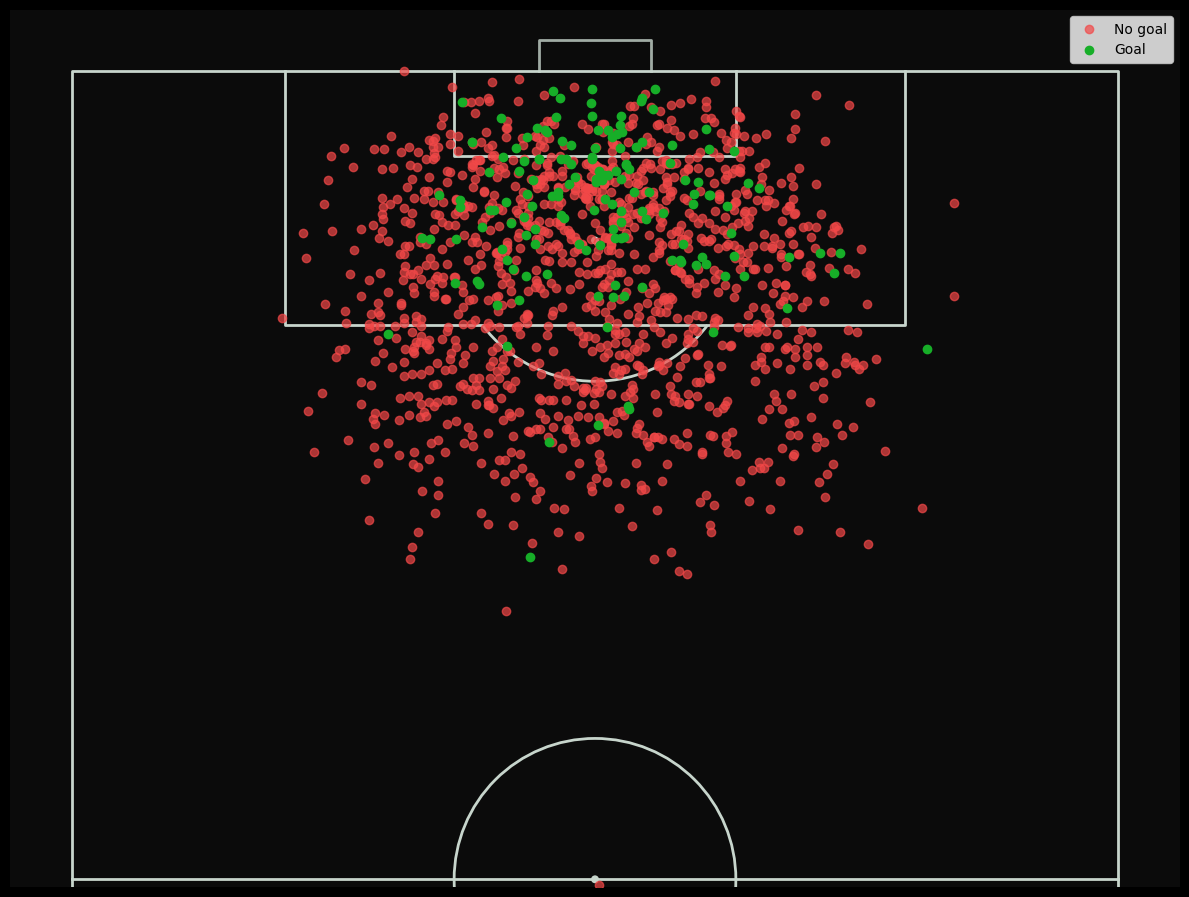

In [198]:
# visualizing shots

# filter goals / non-shot goals
df_goals = shot_df[shot_df.outcome_name == 'Goal'].copy()
df_non_goal_shots = shot_df[shot_df.outcome_name != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pitch_type = 'custom',
                      pitch_length = 105,
                      pitch_width = 68,
                      pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='black', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))
fig.set_facecolor('black')
ax.patch.set_facecolor('#0B0B0B')
sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='#F24848',
                    marker='o',
                    ax=ax, label="No goal",alpha = 0.7)

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='#17AE28',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
#plt.show()
plt.savefig('C:/Users/acer/Documents/GitHub/IndianCitizen/Models/xG/Images/AllShots.png',dpi=500,facecolor=background)

### 360/Tracking Data

In [189]:
track_df.columns

Index(['teammate', 'match_id', 'id', 'x', 'y', 'player_id', 'player_name',
       'position_id', 'position_name', 'event_freeze_id'],
      dtype='object')

In [33]:
track_df.head()

,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
0,False,3857256,61d52e72-a8ff-49c4-be02-057b1ea0fb15,75.4250,43.860,3831,Dušan Tadić,19,Center Attacking Midfield,1
1,False,3857256,61d52e72-a8ff-49c4-be02-057b1ea0fb15,93.9750,51.255,6321,Milos Veljkovic,4,Center Back,2
2,False,3857256,61d52e72-a8ff-49c4-be02-057b1ea0fb15,91.7000,46.410,5589,Sergej Milinković-Savić,11,Left Defensive Midfield,3
3,False,3857256,61d52e72-a8ff-49c4-be02-057b1ea0fb15,89.6000,36.975,6687,Saša Lukić,9,Right Defensive Midfield,4
4,False,3857256,61d52e72-a8ff-49c4-be02-057b1ea0fb15,90.2125,34.000,6318,Andrija Živković,7,Right Wing Back,5


### Plotting a shot with tracking data

In [201]:
df_match_360 = pd.merge(left=shot_df,right=track_df,left_on='id',right_on='id',how='left')

In [203]:
pd.set_option('display.max_columns', None)
df_match_360_shot = df_match_360[df_match_360['id'] == '0021ff25-ec7b-44a6-8268-e4cdbc4bc330']
#df_match_360_shot[df_match_360_shot['position_name_y'] == 'Goalkeeper']

In [204]:
#number of players inside a triangle
def players_in_triangle(df_match_360_shot,id):
    #get id of the shot to search for tracking data using this index
    test_shot_id = id
    test_shot = df_match_360_shot[df_match_360_shot['id'] == id].iloc[0]
    #get all opposition's player location
    player_position = df_match_360_shot.loc[df_match_360_shot["id"] == test_shot_id].loc[track_df["teammate"] == False][["x_y", "y_y"]]
    #checking if point inside a triangle 
    x1 = 105
    #y1 = 34 - 7.32/2
    y1=30
    x2 = 105
    #y2 = 34 + 7.32/2
    y2=38
    x3 = test_shot["x_x"]
    y3 = test_shot["y_x"]
    xp = player_position["x_y"]
    yp = player_position["y_y"]
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1)
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2)
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3)
    #get number of players inside a triangle 
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])

In [237]:
def create_360_shot(id):
    p = VerticalPitch(pitch_type ='custom',
                      pitch_length = 105,
                      pitch_width = 68,
                      pitch_color='grass',
                      line_color='white',
                      stripe_color='#c2d59d', 
                      stripe=True,
                      half=True,
                     line_alpha=0.5, goal_alpha=0.8,corner_arcs=True,goal_type='box')
    fig,ax = p.draw(figsize=(12,8))
    
    # Invert the y-axis
    ax.invert_xaxis()
    
    df_match_360_shot = df_match_360[df_match_360['id'] == id]
    
    
    p.scatter(x=df_match_360_shot['x_x'].iloc[0],y=df_match_360_shot['y_x'].iloc[0],color = 'Yellow',s=100,ax=ax,label='Player taking shot')
    p.lines(xstart=df_match_360_shot['x_x'].iloc[0],ystart=df_match_360_shot['y_x'].iloc[0],xend=df_match_360_shot['end_x'].iloc[0],yend=df_match_360_shot['end_y'].iloc[0],lw=2,alpha=0.7,comet=True,color='white',ax=ax)
    
    opponent_count = 0
    keeper_in_goal = False
    opponent_blocking_shot = players_in_triangle(df_match_360_shot,id)

    
    for idx, row in df_match_360_shot.iterrows():
        if row['teammate'] == True:
            color = 'white'
        elif row['teammate'] == False:
            color = 'blue'
    
        if not row['position_name_y'] == 'Goalkeeper' and row['x_y'] > row['x_x'] and row['y_y'] > row['y_x']:
            opponent_count += 1
    
        if row['position_name_y'] == 'Goalkeeper':
            color = 'red'
            keeper_in_goal = True
    
        pitch.scatter(x=row['x_y'], y=row['y_y'], ax=ax, c=color, s=100)

    if opponent_blocking_shot == -1:
        opponent_blocking_shot = 0
    p.lines(xstart=df_match_360_shot['x_x'].iloc[0],ystart=df_match_360_shot['y_x'].iloc[0],xend=105,yend=30,comet=False,color='black',ax=ax,lw=1.5,alpha=0.5)
    p.lines(xstart=df_match_360_shot['x_x'].iloc[0],ystart=df_match_360_shot['y_x'].iloc[0],xend=105,yend=38,comet=False,color='black',ax=ax,lw=1.5,alpha=0.5)
    
    print("Number of opponents behind the ball: ",opponent_count)
    print("Number of opponents blocking the shot: ",opponent_blocking_shot)
    print("Keeper In Goal: ",keeper_in_goal)
    print("Shot Taken by: ",df_match_360_shot['player_name_x'].iloc[0])
    print("Shot Taken At: ",df_match_360_shot['minute'].iloc[0],":",df_match_360_shot['second'].iloc[0])
    print("Body part used: ",df_match_360_shot['body_part_name'].iloc[0])
    print("Technique used: ",df_match_360_shot['technique_name'].iloc[0])
    print("One on One Shot: ",df_match_360_shot['shot_one_on_one'].iloc[0])
    print("Statsbomb xG: ",df_match_360_shot['shot_statsbomb_xg'].iloc[0])

    # Define custom legend entries
    legend_elements = [
        Line2D([0], [0], marker='o', color='b', markerfacecolor='white', markersize=10, label='Teammate'),
        Line2D([0], [0], marker='o', color='b', markerfacecolor='blue', markersize=10, label='Opponent'),
        Line2D([0], [0], marker='o', color='b', markerfacecolor='red', markersize=10, label='Goalkeeper'),
        Line2D([0], [0], marker='o', color='b', markerfacecolor='yellow', markersize=10, label='Player taking Shot')
    ]
    
    # Add legend
    ax.legend(handles=legend_elements,  bbox_to_anchor=(0.7, 0.92), fontsize=12)
    plt.savefig('C:/Users/acer/Documents/GitHub/IndianCitizen/Models/xG/Images/360Shot.png',dpi=500,facecolor=background)

Number of opponents behind the ball:  6
Number of opponents blocking the shot:  2
Keeper In Goal:  True
Shot Taken by:  Niclas Füllkrug
Shot Taken At:  94 : 58
Body part used:  Right Foot
Technique used:  Half Volley
One on One Shot:  nan
Statsbomb xG:  0.046867393


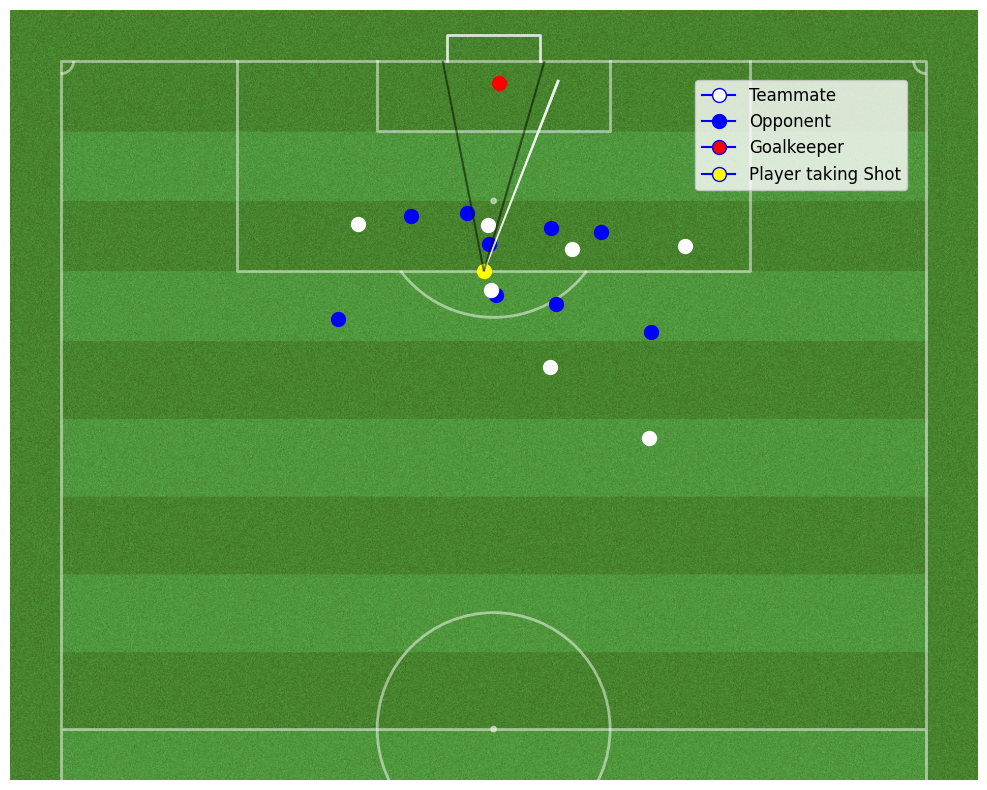

In [238]:
create_360_shot('ffec1808-4db2-49f2-8dcd-6ab8f139b581')

In [209]:
shot_df["sub_type_name"].unique()

array(['Open Play'], dtype=object)

## Feature Engineering

In [210]:
#reset indicies    
shot_df.reset_index(drop=True, inplace=True)    
track_df.reset_index(drop=True, inplace=True)  
#filter out non open-play shots  
shot_df = shot_df.loc[shot_df["sub_type_name"] == "Open Play"]
#filter out shots where goalkeeper was not tracked
gks_tracked = track_df.loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"]['id'].unique()
shot_df = shot_df.loc[shot_df["id"].isin(gks_tracked)]

### Let's create a basic model first Using Logistic Regression taking only distance and angle as features

In [211]:
#take important variables from shot dataframe
model_vars = shot_df[["id", "index", "x", "y"]]
#get the dependent variable
model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
#change the dependent variable to object for basic xG modelling
model_vars["goal_smf"] = model_vars["goal"].astype(object)
# ball location (x)
model_vars['x0'] = model_vars.x
# x to calculate angle and distance
model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)
# c to calculate angle and distance between ball and the goal 
model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))
#calculating angle and distance 
model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)

In [212]:
#calculating basic xG using logistic regression
def params(df):
    test_model = smf.glm(formula="goal_smf ~ angle + distance", data=df,
                               family=sm.families.Binomial()).fit()
    #print summary
    return test_model.params
def calculate_xG(sh, b):
   bsum=b[0]
   for i,v in enumerate(["angle", "distance"]):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#expected goals based on distance to goal and angle between the ball and the goal
b = params(model_vars)
model_vars["xg_basic"]= model_vars.apply(calculate_xG, b = b, axis=1)

In [172]:
model_vars.head()

,id,index,x,y,goal,goal_smf,x0,c,angle,distance,xg_basic
0,61d52e72-a8ff-49c4-be02-057b1ea0fb15,20,21.0000,32.980,0,0,84.0000,1.020,19.728778,21.024757,0.041139
1,aa77495b-0e7b-44f0-a2eb-11605085943a,25,6.0375,34.595,0,0,98.9625,0.595,62.089827,6.066748,0.304122
2,51026369-a4ad-4a71-b14a-6e7f8b764772,28,14.1750,35.615,0,0,90.8250,1.615,28.621257,14.266704,0.091489
3,6ac240f5-8b84-4c06-8153-b56109c8c5e6,196,6.8250,31.280,0,0,98.1750,2.720,50.911849,7.347042,0.236770
4,00e599c0-5234-4b6a-9b91-d6f789a311b0,356,19.4250,43.775,0,0,85.5750,9.775,17.195042,21.745833,0.036613


### Taking some other columns provided by Statsbomb for our model

In [240]:
model_vars = shot_df[["x", "y","under_pressure","body_part_name","technique_name","shot_one_on_one","end_x", "end_y"]]

#get the dependent variable
model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
#change the dependent variable to object for basic xG modelling
model_vars["goal_smf"] = model_vars["goal"].astype(object)
# ball location (x)
model_vars['x0'] = model_vars.x
# x to calculate angle and distance
model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)
# c to calculate angle and distance between ball and the goal 
model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))
#calculating angle and distance 
model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)

model_vars['under_pressure'] = model_vars['under_pressure'].fillna(0)
model_vars['under_pressure'] = model_vars['under_pressure'].astype(int)

model_vars['shot_one_on_one'] = model_vars['shot_one_on_one'].fillna(0)
model_vars['shot_one_on_one'] = model_vars['shot_one_on_one'].astype(int)

# one hot encoding for techniques and sub types
model_vars = pd.get_dummies(model_vars, columns = ['body_part_name'])
#model_vars = pd.get_dummies(model_vars, columns = ['sub_type_name'])
model_vars = pd.get_dummies(model_vars, columns = ['technique_name'])

In [241]:
model_vars.columns

Index(['x', 'y', 'under_pressure', 'shot_one_on_one', 'end_x', 'end_y', 'goal',
       'goal_smf', 'x0', 'c', 'angle', 'distance', 'body_part_name_Head',
       'body_part_name_Left Foot', 'body_part_name_Other',
       'body_part_name_Right Foot', 'technique_name_Backheel',
       'technique_name_Diving Header', 'technique_name_Half Volley',
       'technique_name_Lob', 'technique_name_Normal',
       'technique_name_Overhead Kick', 'technique_name_Volley'],
      dtype='object')

### Creating functions for user defined features

In [242]:
#number of players inside a triangle
def players_in_triangle(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    #checking if point inside a triangle 
    x1 = 105
    y1 = 34 - 7.32/2
    x2 = 105
    y2 = 34 + 7.32/2
    x3 = test_shot["x"]
    y3 = test_shot["y"]
    xp = player_position["x"]
    yp = player_position["y"]
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1)
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2)
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3)
    #get number of players inside a triangle 
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])

#store number of opposition's players inside a triangle in a dataframe 
model_vars["triangle"] = shot_df.apply(players_in_triangle, track_df = track_df, axis = 1)

In [243]:
#ball_goalkeeper distance
def dist_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #check goalkeeper position 
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate distance from event to goalkeeper position
    dist = np.sqrt((test_shot["x"] - gk_pos["x"])**2 + (test_shot["y"] - gk_pos["y"])**2)
    return dist.iloc[0]
#store distance from event to goalkeeper position in a dataframe 
model_vars["gk_distance"] = shot_df.apply(dist_to_gk, track_df = track_df, axis = 1)

In [244]:
#ball goalkeeper y axis
def y_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #calculate distance from event to goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["y"]]
    #calculate distance from event to goalkeeper position in y axis
    dist = abs(test_shot["y"] - gk_pos["y"])
    return dist.iloc[0]

#store distance in y axis from event to goalkeeper position in a dataframe 
model_vars["gk_distance_y"] = shot_df.apply(y_to_gk, track_df = track_df, axis = 1)

In [245]:
#number of players less than 3 meters away from the ball
def three_meters_away(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    #calculate their distance to the ball
    dist = np.sqrt((test_shot["x"] - player_position["x"])**2 + (test_shot["y"] - player_position["y"])**2)
    #return how many are closer to the ball than 3 meters
    return len(dist[dist<3])
#store number of opposition's players closer than 3 meters in a dataframe 
model_vars["close_players"] = shot_df.apply(three_meters_away, track_df = track_df, axis = 1)

In [246]:
#goalkeeper distance to goal
def gk_dist_to_goal(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate their distance to goal
    dist = np.sqrt((105 -gk_pos["x"])**2 + (34 - gk_pos["y"])**2)
    return dist.iloc[0]

#store opposition's goalkeeper distance to goal in a dataframe 
model_vars["gk_dist_to_goal"] = shot_df.apply(gk_dist_to_goal, track_df = track_df, axis = 1)

In [247]:
#create binary varibale 1 if ball is closer to the goal than goalkeeper
model_vars["is_closer"] = np.where(model_vars["gk_dist_to_goal"] > model_vars["distance"], 1, 0)

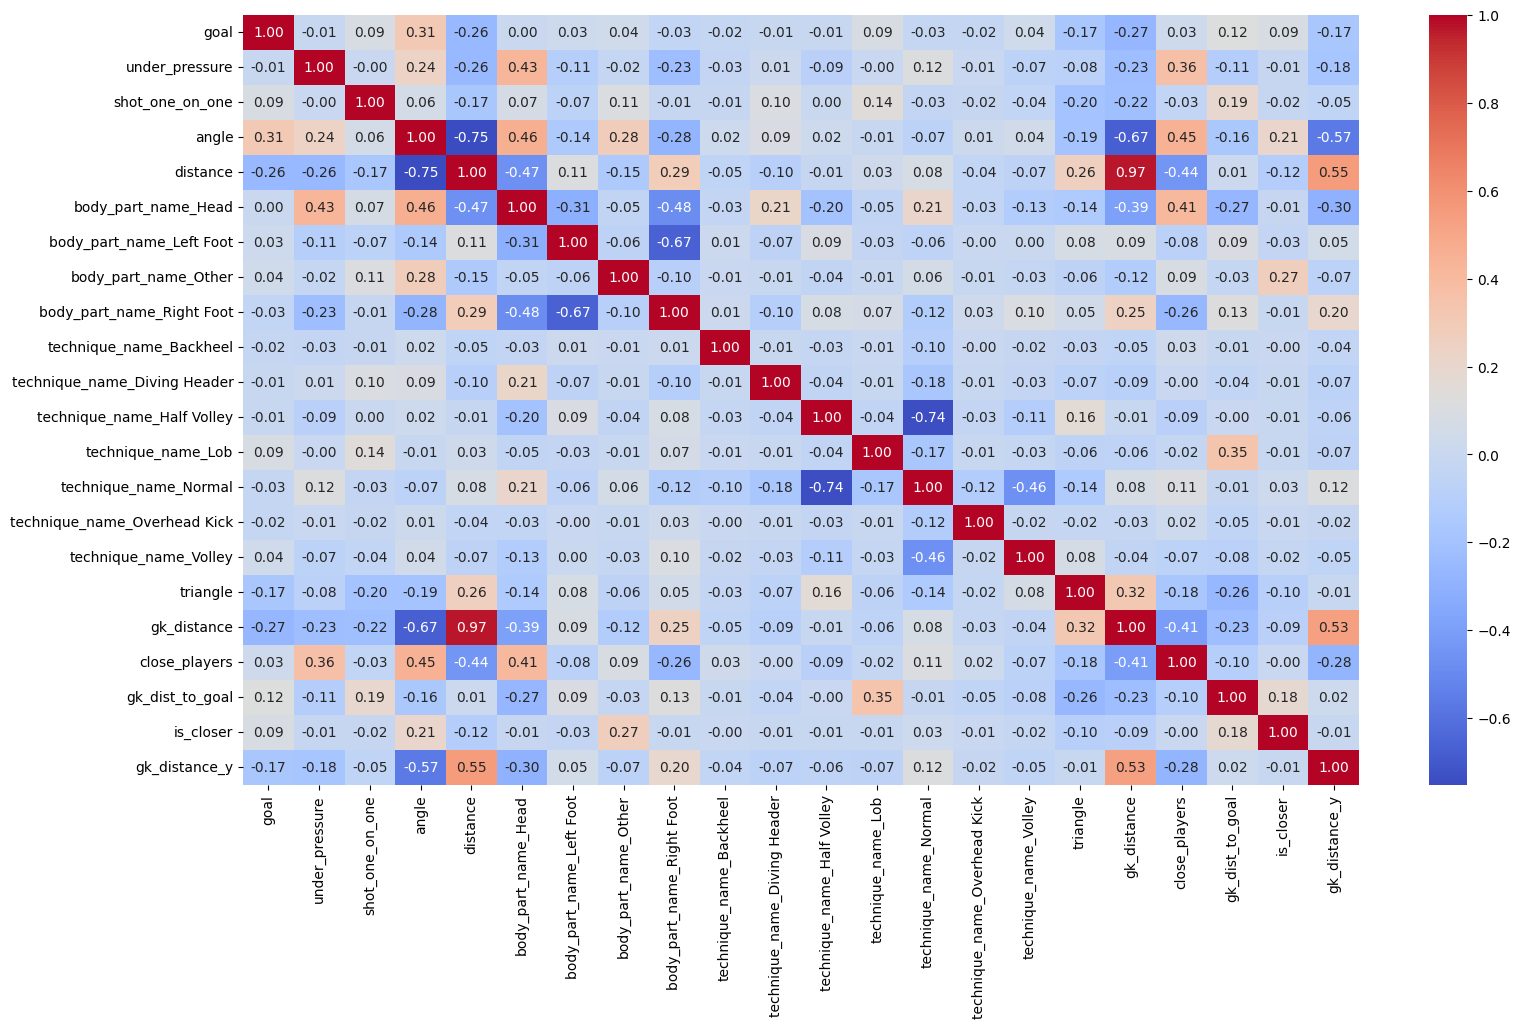

In [250]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_vars = model_vars[['goal','under_pressure', 'shot_one_on_one','angle', 'distance', 'body_part_name_Head',
       'body_part_name_Left Foot', 'body_part_name_Other',
       'body_part_name_Right Foot', 'technique_name_Backheel',
       'technique_name_Diving Header', 'technique_name_Half Volley',
       'technique_name_Lob', 'technique_name_Normal',
       'technique_name_Overhead Kick', 'technique_name_Volley', 'triangle',
       'gk_distance', 'close_players', 'gk_dist_to_goal','is_closer','gk_distance_y']]
# Calculate the correlation matrix
correlation_matrix = corr_vars.corr()

# Display the correlation matrix
#print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#plt.show()
plt.savefig('C:/Users/acer/Documents/GitHub/IndianCitizen/Models/xG/Images/Corr.png',dpi=500,facecolor='white')

## Training Neural Network Model
### With the features created we can now train a neural network. We split the data 60% training, 20% validation and 20% test. Then, we scale inputs. 
### As the next step, we create a neural network model. It follows similar design choices as Javier Fernandez's one. 2 dense layers sized 10 followed 
### by a ReLU activation and a final layer size 1 with sigmoid activation to compute the probabilities. Our model optimizes the Brier score using Adam
### optimizer with learning rate 0.001 default betas. We use as suggested early stopping with minimum delta 1e-5 and batch size 16. However, we also use patience equal to 50 not to stop the first time when the validation loss is not changing.

In [255]:
#store dependent variable in a numpy array
y = model_vars["goal"].values
#store independent variables in a numpy array
X = model_vars[["is_closer", "angle", "distance", "gk_distance","gk_distance_y", "triangle", "close_players", "under_pressure", "shot_one_on_one"
               ,'body_part_name_Head','body_part_name_Left Foot', 'body_part_name_Other','body_part_name_Right Foot', 'technique_name_Backheel',
               'technique_name_Diving Header', 'technique_name_Half Volley','technique_name_Lob', 'technique_name_Normal',
                 'technique_name_Overhead Kick', 'technique_name_Volley']].values

#spllit the data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_cal = scaler.transform(X_cal)

#creating a function with a model architecture
def create_model():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss="mean_squared_error" , metrics=['accuracy'])
    return model

Epoch 1/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7531 - loss: 0.1959 - val_accuracy: 0.8159 - val_loss: 0.1469
Epoch 2/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8491 - loss: 0.1341 - val_accuracy: 0.8809 - val_loss: 0.1207
Epoch 3/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.1123 - val_accuracy: 0.8881 - val_loss: 0.1095
Epoch 4/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8831 - loss: 0.1036 - val_accuracy: 0.8881 - val_loss: 0.1039
Epoch 5/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.0992 - val_accuracy: 0.8917 - val_loss: 0.1005
Epoch 6/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.0965 - val_accuracy: 0.8917 - val_loss: 0.0982
Epoch 7/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.0945 - val_accuracy: 0.8917 - val_loss: 0.0965
Epoch 8/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.0929 - val_accuracy: 0.

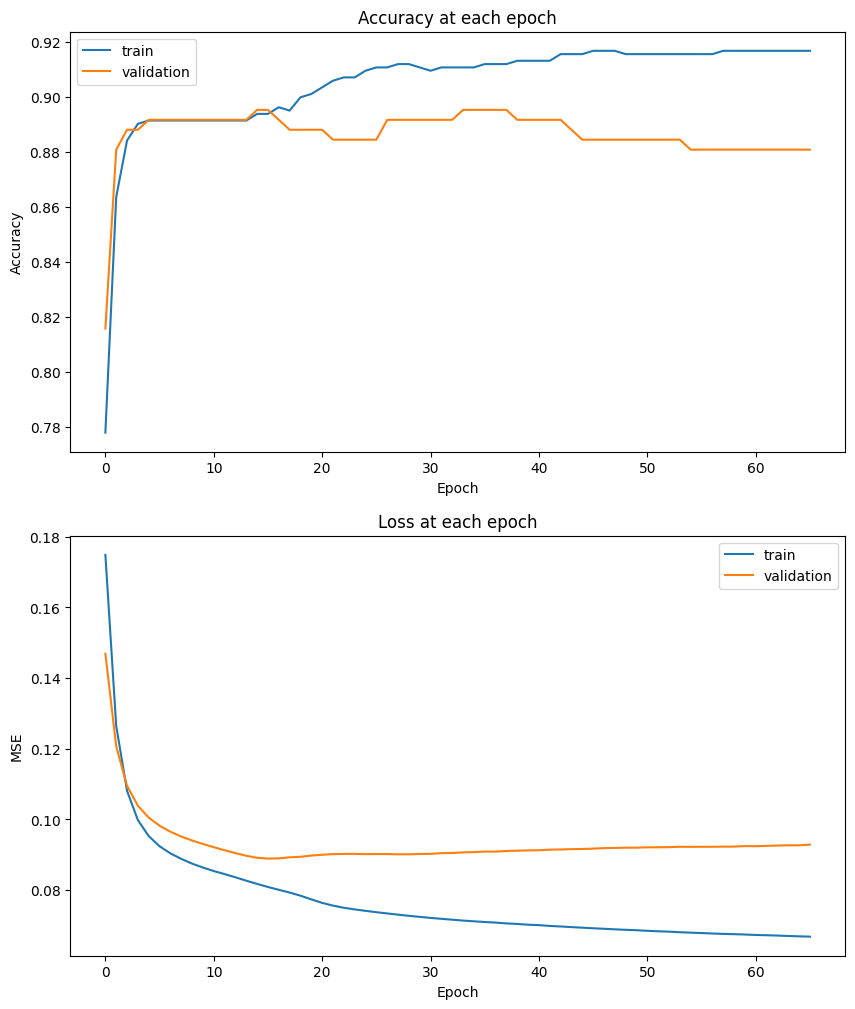

In [256]:
#create model
model = create_model()
#create an early stopping object
callback = EarlyStopping(min_delta=1e-5, patience = 50, mode = "min", monitor = "val_loss", restore_best_weights=True)
#fit the model 
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=16, callbacks = [callback])

fig, axs = plt.subplots(2, figsize=(10,12))
#plot training history - accuracy
axs[0].plot(history.history['accuracy'], label='train')   
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

#plot training history - loss function
axs[1].plot(history.history['loss'], label='train')   
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
#plt.show()
plt.savefig('C:/Users/acer/Documents/GitHub/IndianCitizen/Models/xG/Images/Accuracy.png',dpi=500,facecolor='white')

### To assess our model, we calculate ROC AUC and investigate calibration curves. From the plots we can see that some of higher probabilities are  underestimated by our model, but these are satisfactory results given the number of data we have and a shallow network. Also, we calculate Brier scor # on unseen data. It amounts to 0.08, which is a good score.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step


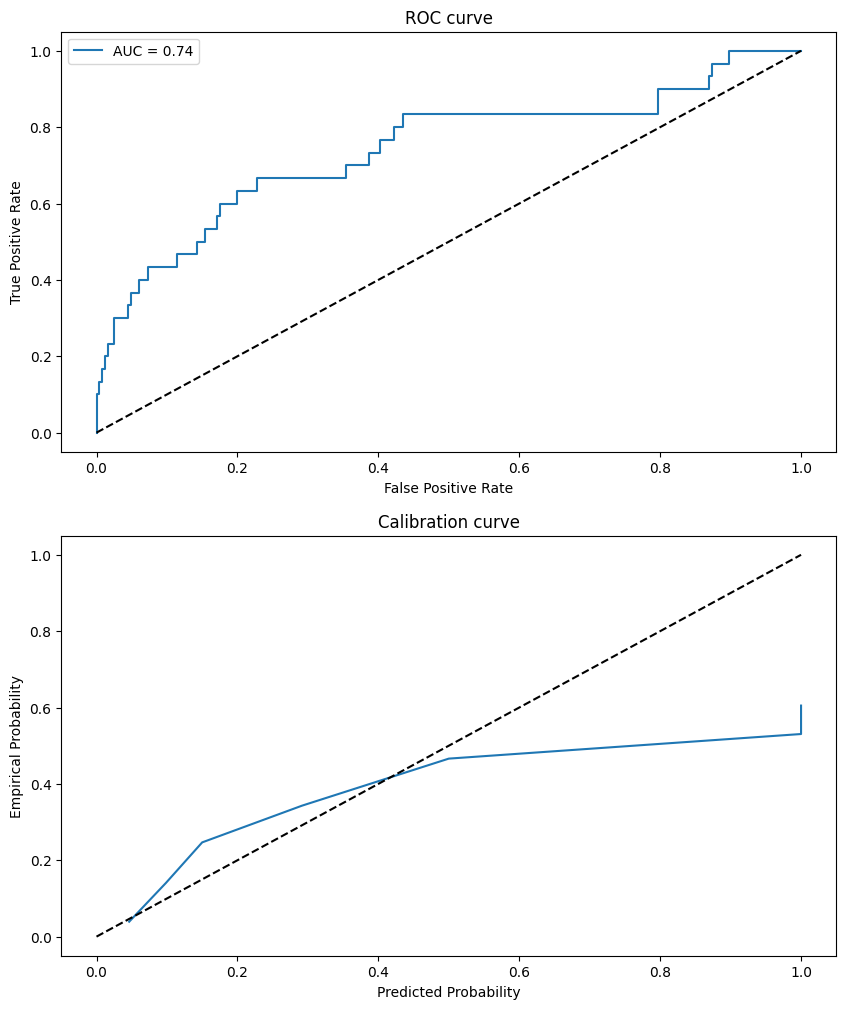

Brier score 0.08490296649064209


<Figure size 640x480 with 0 Axes>

In [262]:
#ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
fig, axs = plt.subplots(2, figsize=(10,12))
y_pred = model.predict(X_cal)
fpr, tpr, _ = roc_curve(y_cal,  y_pred)
auc = roc_auc_score(y_cal, y_pred)
axs[0].plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
axs[0].plot([0, 1], [0, 1], color='black', ls = '--')
axs[0].legend()
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title('ROC curve')

#CALIBRATION CURVE
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10)
axs[1].plot(prob_true, prob_pred)
axs[1].plot([0, 1], [0, 1], color='black', ls = '--')
axs[1].set_ylabel('Empirical Probability')
axs[1].set_xlabel('Predicted Probability')
axs[1].set_title("Calibration curve")
plt.show()
#Brier score
print("Brier score", brier_score_loss(y_cal, y_pred))
plt.savefig('C:/Users/acer/Documents/GitHub/IndianCitizen/Models/xG/Images/ROC_Brier.png',dpi=500)

## Evaluation

### Calculating xG using our model for Bayer Leverkusen 2023/24 season for which data has been recently released by Statsbomb. We apply the same data transformations as on our training dataset. As the next step we scale our data and make predictions on them. Then, we try to find out 5 players that accumulated the highest open play Expected Goals.

In [263]:
df_match2 = parser.match(competition_id=9, season_id=281)
#get array of match ids
matches2 = df_match2.match_id.unique()
shot_df2 = pd.DataFrame()
track_df2 = pd.DataFrame()
#for each match store shots and trackings in dataframes for the entire season
for match in matches2:
    df_event = parser.event(match)[0]
    df_track = parser.event(match)[2]
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)
    
    shot_df2 = pd.concat([shot_df2, shots], ignore_index = True)
    track_df2 = pd.concat([track_df2, df_track], ignore_index = True)

In [264]:
shot_df2.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,outcome_id,outcome_name,counterpress,out,aerial_won,off_camera,pass_switch,pass_cross,shot_statsbomb_xg,shot_first_time,technique_id,technique_name,goalkeeper_position_id,goalkeeper_position_name,pass_assisted_shot_id,pass_shot_assist,end_z,shot_key_pass_id,injury_stoppage_in_chain,foul_won_defensive,ball_recovery_recovery_failure,foul_committed_advantage,foul_won_advantage,pass_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,foul_committed_card_id,foul_committed_card_name,block_save_block,shot_one_on_one,substitution_replacement_id,substitution_replacement_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_cut_back,pass_goal_assist,dribble_nutmeg,dribble_overrun,block_offensive,ball_recovery_offensive,shot_deflected,foul_committed_offensive,pass_miscommunication,pass_no_touch,shot_open_goal,dribble_no_touch
0,c577e730-b9f5-44f2-9257-9e7730c23d7b,436,1,00:06:48.773000,6,48,13,0.052872,3895302,16,Shot,176,Werder Bremen,3,From Free Kick,176,Werder Bremen,None,8826.0,Leonardo Bittencourt,13.0,Right Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,101.6,35.2,40.0,Right Foot,87.0,Open Play,87.8500,29.835,NaN,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,0.056644,True,93.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bbc2c68d-c096-483d-abf4-32c0175a0f55,480,1,00:07:40.953000,7,40,14,0.217872,3895302,16,Shot,904,Bayer Leverkusen,1,Regular Play,904,Bayer Leverkusen,None,38004.0,Piero Martín Hincapié Reyna,8.0,Left Wing Back,NaN,NaN,NaN,NaN,NaN,NaN,118.1,35.7,38.0,Left Foot,87.0,Open Play,100.2750,28.475,1.0,100.0,Saved,NaN,NaN,NaN,NaN,NaN,NaN,0.143381,True,93.0,Normal,NaN,NaN,NaN,NaN,0.2,95ee2820-c4dc-44f2-9fe7-d24cb6edd881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12b5206b-9ed0-4b1e-9ec3-f2028187e09f,597,1,00:11:08.471000,11,8,22,0.445768,3895302,16,Shot,176,Werder Bremen,3,From Free Kick,176,Werder Bremen,None,51769.0,Julián Malatini,3.0,Right Center Back,NaN,NaN,NaN,NaN,NaN,NaN,113.4,46.8,38.0,Left Foot,87.0,Open Play,92.9250,47.430,NaN,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,0.038188,True,93.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b2c3d59d-3bef-4f8a-ad86-26b69940c64e,684,1,00:13:16.073000,13,16,26,0.085298,3895302,16,Shot,904,Bayer Leverkusen,2,From Corner,904,Bayer Leverkusen,None,8221.0,Jonathan Tah,4.0,Center Back,NaN,NaN,NaN,NaN,NaN,NaN,114.1,46.8,37.0,Head,87.0,Open Play,99.6625,40.290,NaN,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,0.052781,NaN,93.0,Normal,NaN,NaN,NaN,NaN,NaN,f11e6dbe-665c-4c05-a7cb-aa361d8a0bf2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bb53b537-1685-4019-9e8f-98f3805828eb,848,1,00:16:00.956000,16,0,33,0.402989,3895302,16,Shot,904,Bayer Leverkusen,1,Regular Play,904,Bayer Leverkusen,None,3500.0,Granit Xhaka,9.0,Right Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,101.4,41.3,38.0,Left Foot,87.0,Open Play,78.0500,36.125,1.0,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,0.021272,NaN,93.0,Normal,NaN,NaN,NaN,NaN,NaN,576aece9-65d9-43bb-bb33-48c2943ef53f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
shot_df2.shape

(916, 84)

In [265]:
track_df2.head()

,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
0,False,3895302,c577e730-b9f5-44f2-9257-9e7730c23d7b,89.1625,29.835,3500,Granit Xhaka,9,Right Defensive Midfield,1
1,False,3895302,c577e730-b9f5-44f2-9257-9e7730c23d7b,93.8000,32.385,30606,Edmond Fayçal Tapsoba,5,Left Center Back,2
2,False,3895302,c577e730-b9f5-44f2-9257-9e7730c23d7b,98.7875,36.040,38004,Piero Martín Hincapié Reyna,8,Left Wing Back,3
3,False,3895302,c577e730-b9f5-44f2-9257-9e7730c23d7b,96.6000,24.990,8221,Jonathan Tah,4,Center Back,4
4,False,3895302,c577e730-b9f5-44f2-9257-9e7730c23d7b,80.5875,24.650,8804,Jonas Hofmann,18,Right Attacking Midfield,5


In [267]:
#reset indicies and remove shots that were not open play or when the goalkeeper was not tracked
shot_df2 = shot_df2.loc[(shot_df2["sub_type_name"] == "Open Play") & (shot_df2["team_name"] == "Bayer Leverkusen")]   
shot_df2.reset_index(drop=True, inplace=True)
track_df2.reset_index(drop=True, inplace=True)
gks_tracked2 = track_df2.loc[track_df2["teammate"] == False].loc[track_df2["position_name"] == "Goalkeeper"]['id'].unique()
shot_df2 = shot_df2.loc[shot_df2["id"].isin(gks_tracked2)]

In [268]:
shot_df2.shape

(594, 84)

In [269]:
track_df2.shape

(13535, 10)

In [270]:
shot_df2.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'under_pressure',
       'outcome_id', 'outcome_name', 'counterpress', 'out', 'aerial_won',
       'off_camera', 'pass_switch', 'pass_cross', 'shot_statsbomb_xg',
       'shot_first_time', 'technique_id', 'technique_name',
       'goalkeeper_position_id', 'goalkeeper_position_name',
       'pass_assisted_shot_id', 'pass_shot_assist', 'end_z',
       'shot_key_pass_id', 'injury_stoppage_in_chain', 'foul_won_defensive',
      

## DATA WRANGLING. DESCRIPTION OF THESE STEPS CAN BE FOUND IN FEATURE ENGINEERING PART

In [276]:
model_vars2 = shot_df2[["x", "y","under_pressure","body_part_name","technique_name","shot_one_on_one","end_x", "end_y"]]
model_vars2["goal"] = shot_df2.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
model_vars2["goal_smf"] = model_vars2["goal"].astype(object)
model_vars2['x0'] = model_vars2.x
model_vars2["x"] = model_vars2.x.apply(lambda cell: 105-cell)
model_vars2["c"] = model_vars2.y.apply(lambda cell: abs(34-cell))
model_vars2["angle"] = np.where(np.arctan(7.32 * model_vars2["x"] / (model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars2["distance"] = np.sqrt(model_vars2["x"]**2 + model_vars2["c"]**2)
model_vars2["xg_basic"]= model_vars2.apply(calculate_xG, b = b, axis=1)
model_vars2["gk_distance"] = shot_df2.apply(dist_to_gk, track_df = track_df2, axis = 1)
model_vars2["gk_distance_y"] = shot_df2.apply(y_to_gk, track_df = track_df2, axis = 1)
model_vars2["triangle"] = shot_df2.apply(players_in_triangle, track_df = track_df2, axis = 1)
model_vars2["close_players"] = shot_df2.apply(three_meters_away, track_df = track_df2, axis = 1)
model_vars2["gk_dist_to_goal"] = shot_df2.apply(gk_dist_to_goal, track_df = track_df2, axis = 1)
model_vars2["is_closer"] = np.where(model_vars2["gk_dist_to_goal"] > model_vars2["distance"], 1, 0)
#model_vars2["header"] = shot_df2.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)
model_vars2['under_pressure'] = model_vars2['under_pressure'].fillna(0)
model_vars2['under_pressure'] = model_vars2['under_pressure'].astype(int)

model_vars2['shot_one_on_one'] = model_vars2['shot_one_on_one'].fillna(0)
model_vars2['shot_one_on_one'] = model_vars2['shot_one_on_one'].astype(int)

# one hot encoding for techniques and sub types
model_vars2 = pd.get_dummies(model_vars2, columns = ['body_part_name'])
model_vars2 = pd.get_dummies(model_vars2, columns = ['technique_name'])

In [279]:
model_vars2.shape

(594, 30)

In [272]:
model_vars2.head()

,x,y,under_pressure,shot_one_on_one,end_x,end_y,goal,goal_smf,x0,c,angle,distance,xg_basic,gk_distance,gk_distance_y,triangle,close_players,gk_dist_to_goal,is_closer,body_part_name_Head,body_part_name_Left Foot,body_part_name_Other,body_part_name_Right Foot,technique_name_Backheel,technique_name_Half Volley,technique_name_Lob,technique_name_Normal,technique_name_Overhead Kick,technique_name_Volley
0,4.7250,28.475,1,0,118.1,35.7,0,0,100.2750,5.525,41.237951,7.269887,0.206329,4.069107,2.465,1,1,3.402390,0,False,True,False,False,False,False,False,True,False,False
1,5.3375,40.290,0,0,114.1,46.8,0,0,99.6625,6.290,35.558146,8.249425,0.174420,6.402831,4.675,1,3,1.880062,0,True,False,False,False,False,False,False,True,False,False
2,26.9500,36.125,1,0,101.4,41.3,0,0,78.0500,2.125,15.374975,27.033648,0.021049,24.323199,2.040,3,1,2.713831,0,False,True,False,False,False,False,False,True,False,False
3,8.5750,27.710,1,0,116.4,38.1,0,0,96.4250,6.290,32.193872,10.634600,0.134696,9.336265,5.015,2,3,1.454519,0,True,False,False,False,False,False,False,True,False,False
4,16.1875,40.375,0,0,103.2,47.1,0,0,88.8125,6.375,22.274572,17.397580,0.061034,15.264747,5.440,5,1,2.140058,0,False,True,False,False,False,False,False,True,False,False


In [278]:
model_vars2['technique_name_Diving Header'] = False

In [280]:
#store data in a matrix
X_unseen = model_vars2[["is_closer", "angle", "distance", "gk_distance","gk_distance_y", "triangle", "close_players", "under_pressure", "shot_one_on_one"
               ,'body_part_name_Head','body_part_name_Left Foot', 'body_part_name_Other','body_part_name_Right Foot', 'technique_name_Backheel', 'technique_name_Half Volley','technique_name_Lob', 'technique_name_Normal',
                 'technique_name_Overhead Kick', 'technique_name_Volley','technique_name_Diving Header']].values
#scale data
X_unseen = scaler.transform(X_unseen)
#make predictions
xgs_bayer = model.predict(X_unseen)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


In [283]:
#find out which 5 players had the highest xG
shot_df2["our_xG"] = xgs_bayer
shot_df2.groupby(["player_name"])["our_xG"].sum().sort_values(ascending = False)[:5].reset_index()

,player_name,our_xG
0,Victor Okoh Boniface,14.535835
1,Jeremie Frimpong,8.117919
2,Florian Wirtz,6.756936
3,Patrik Schick,5.982202
4,Jonas Hofmann,5.712743


In [285]:
#find out which 5 players had the highest xG
shot_df2.groupby(["player_name"])["shot_statsbomb_xg"].sum().sort_values(ascending = False)[:5].reset_index()

,player_name,shot_statsbomb_xg
0,Victor Okoh Boniface,12.836215
1,Jeremie Frimpong,8.719662
2,Florian Wirtz,7.662212
3,Jonas Hofmann,5.709160
4,Patrik Schick,4.663658
